In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from glob import glob
import os
import tensorflow as tf
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import re
from tensorflow.keras.applications import EfficientNetB0, MobileNet
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam


In [ ]:
BATCH_SIZE = 4

# Plate Localizer

## Preparing The Dataset

In [3]:
def preprocess(path):
  image = tf.io.read_file(path)

  image = tf.io.decode_jpeg(image)

  image = tf.image.resize(image, (224,224))

  image = image/255
  return image

In [4]:
################################## Train Dataset ###################################

# Create a dataset for the images containing car plates.
# image dataset
image_paths_with_plate = sorted(glob(os.path.join('/content','drive','MyDrive','car_tag_data','data','train_data','with_plate','*.jpg')))
images_dataset_with_plate = tf.data.Dataset.from_tensor_slices(image_paths_with_plate)
images_dataset_with_plate = images_dataset_with_plate.map(preprocess)

# label dataset
json_labels_path = '/content/drive/MyDrive/car_tag_data/data/train_label'
labels_list = []
for filename in sorted(os.listdir(json_labels_path)):
    f = open(os.path.join(json_labels_path, filename))
    data = json.load(f)
    img_W, img_H = data['images'][0]['width'],data['images'][0]['height']
    rounded_labels_list = [float(number/img_W) if idx%2==0 else float(number/img_H) for idx, number in enumerate(data['annotations'][0]['bbox'])]
    rounded_labels_list.insert(0, 1)
    labels_list.append(rounded_labels_list)

labels_dataset_with_plate = tf.data.Dataset.from_tensor_slices(labels_list)
# zip together
train_dataset_with_plate = tf.data.Dataset.zip((images_dataset_with_plate, labels_dataset_with_plate))

# Create a dataset for the images not containing car plates.
# image dataset
image_paths_no_plate = sorted(glob(os.path.join('/content','drive','MyDrive','car_tag_data','data','train_data','no_plate','*.jpg')))
images_dataset_no_plate = tf.data.Dataset.from_tensor_slices(image_paths_no_plate)
images_dataset_no_plate = images_dataset_no_plate.map(preprocess)

# label dataset
labels_dataset_no_plate = tf.data.Dataset.from_tensor_slices(tf.zeros(shape=(len(image_paths_no_plate), 5)))
# zip together
train_dataset_no_plate = tf.data.Dataset.zip((images_dataset_no_plate, labels_dataset_no_plate))

# concatenate both with plate and no plate datasets together
train_data = train_dataset_with_plate.concatenate(train_dataset_no_plate)

# shuffle and batch the data
train_data = train_data.shuffle(len(train_data))
train_data_batched = train_data.batch(BATCH_SIZE)

################################## Test Dataset ###################################

test_images_paths = sorted(glob(os.path.join('/content','drive','MyDrive','car_tag_data','data','test_data','*.jpg')))
test_images_dataset = tf.data.Dataset.from_tensor_slices(test_images_paths)
test_images_dataset = test_images_dataset.map(preprocess)
test_data_batched = test_images_dataset.batch(1)


## Visualize Data

In [5]:
iterator = iter(train_data)

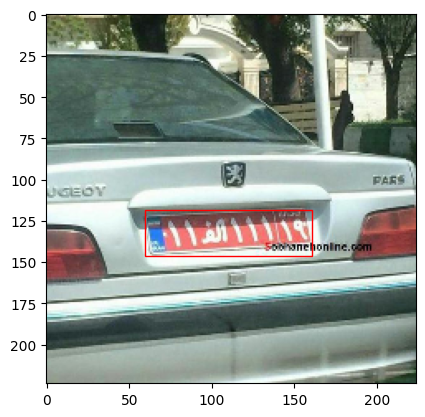

In [70]:
i = next(iterator)
img = i[0]
label = i[1]
fig, ax = plt.subplots(1)
rect = plt.Rectangle((label[1] * 224 ,label[2]*224), label[3]*224,label[4]*224,
                      linewidth = 1,
                      edgecolor = 'r', 
                      facecolor = 'none')
ax.imshow(img)
ax.add_patch(rect)

## Create And Train The Model

In [7]:
def create_model(input_shape): # (224,224,3)
  # Use a pretrained model(MobileNet in our case) for feature extraction.
  base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)

  # Freeze the layers of the pretrained model.
  for layer in base_model.layers:
      layer.trainable = False
  x = Conv2D(256,1, padding = 'same', activation = 'relu')(base_model.output)
  x = Flatten()(x)
  x = Dense(256 ,activation = 'relu')(x)
  x = Dense(128, activation = 'relu')(x)
  output = Dense(5, activation = 'sigmoid')(x)
  model = tf.keras.models.Model(inputs = base_model.input, outputs = output)
  return model

In [8]:
# create custom loss function
def loss_fn(y, y_hat):
  bce1 = binary_crossentropy(y[:,1:],y_hat[:,1:])
  bce2 = binary_crossentropy(y[:,0],y_hat[:,0])
  return y[:,0] * bce1 + 0.5* bce2

In [32]:
model = create_model((224,224,3))
model.compile(loss=loss_fn, optimizer=Adam(learning_rate=.002))

In [ ]:
history = model.fit(train_data_batched,epochs=50)

## Visualize predictions on trainset


In [57]:
iterator_ = iter(train_data_batched)

1/1 [==============================] - 0s 63ms/step


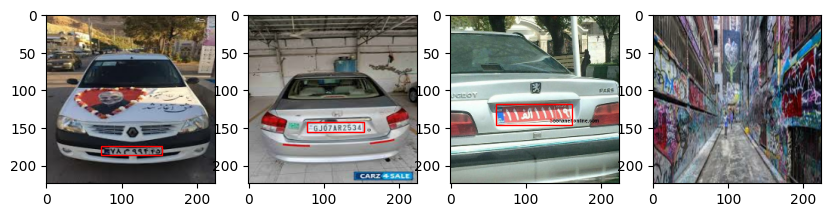

In [63]:
i_ = next(iterator_)
fig, ax = plt.subplots(1,BATCH_SIZE,figsize=(10,10))

for idx, img in enumerate(i_[0]):
  label = model.predict(tf.expand_dims(img, 0))
  if tf.round(label[0][0]):
    rect = plt.Rectangle((label[0][1] * 224 ,label[0][2]*224), label[0][3]*224,label[0][4]*224,
                          linewidth = 1,
                          edgecolor = 'r', 
                          facecolor = 'none')
    ax[idx].imshow(img)
    ax[idx].add_patch(rect)
  else:
    ax[idx].imshow(img)


## Visualize predictions on testset


In [66]:
iterator__ = iter(test_images_dataset)

1/1 [==============================] - 0s 146ms/step


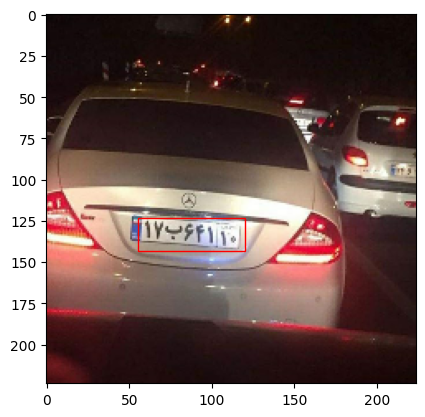

In [69]:
i__ = next(iterator__)
img = i__

label = model.predict(tf.expand_dims(img, 0))
fig, ax = plt.subplots(1)
if tf.round(label[0][0]):
  rect = plt.Rectangle((label[0][1] * 224 ,label[0][2]*224), label[0][3]*224,label[0][4]*224,
                        linewidth = 1,
                        edgecolor = 'r', 
                        facecolor = 'none')
  ax.imshow(img)
  ax.add_patch(rect)
else:
  ax.imshow(img)

## Crop the plate based on the predictions

In [ ]:
plate_only_images = []
for image,_ in train_data: # _ is the corresponding label.
  label = model.predict(tf.expand_dims(image,0))
  label = tf.cast(label * 224, dtype=tf.int32)
  label = label[0]
  if label[0]>120:
    x_top_left = label[1]
    y_top_left = label[2]
    width = label[3]
    height = label[4]
    image = image[y_top_left:y_top_left+height,x_top_left:x_top_left+width,:]
    image = tf.image.resize(image, (64,128))
    plate_only_images.append(image)

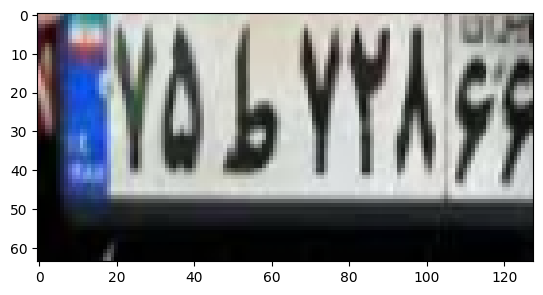

In [ ]:
plt.imshow(plate_only_images[12])